**Notes for autoencoders, to be continued...**

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from typing import Tuple

import warnings
warnings.filterwarnings("ignore")

In [2]:
IMAGE_X = 28
IMAGE_Y = 28
IMAGE_CH = 1

TEST_SIZE = 8
EPOCHS = 50

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32').reshape(-1, IMAGE_Y, IMAGE_X, IMAGE_CH) / 255
X_test = X_test.astype('float32').reshape(-1, IMAGE_Y, IMAGE_X, IMAGE_CH) / 255

test_imgs = X_test[:TEST_SIZE]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
def show_images(imgs: np.ndarray, size: Tuple[int, int] = None):
    if size is None:
        rows, cols = 2, 8
    else:
        rows, cols = size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for ax, img in zip(axes.flatten(), imgs):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

# Simple autoencoder

In [5]:
HIDDEN_DIM = 48

input_layer = Input(shape=(IMAGE_Y, IMAGE_X, IMAGE_CH))

encoder = Sequential([
    input_layer,
    Flatten(),
    Dense(HIDDEN_DIM, activation='relu')
])

decoder = Sequential([
    Input(shape=(HIDDEN_DIM,)),
    Dense(IMAGE_Y * IMAGE_X * IMAGE_CH, activation='sigmoid'),
    Reshape((IMAGE_Y, IMAGE_X, IMAGE_CH))
])

autoencoder = Model(input_layer, decoder(encoder(input_layer)), name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 48)                37680     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         38416     
Total params: 76,096
Trainable params: 76,096
Non-trainable params: 0
_________________________________________________________________


2021-12-12 10:32:32.877393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 10:32:32.978360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 10:32:32.979030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 10:32:32.980321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)],
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2021-12-12 10:32:35.976417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
encoded_imgs = encoder.predict(test_imgs, batch_size=TEST_SIZE)
encoded_imgs[0]

array([ 1.9342958,  1.709883 ,  2.086073 ,  6.8732924,  8.675204 ,
        8.850324 ,  3.48344  ,  3.6755495,  8.067342 ,  7.0469933,
        4.450776 ,  4.010088 ,  6.458554 ,  6.3832135,  2.6320448,
        5.3649645,  5.072134 ,  6.0082417, 11.831345 ,  3.717791 ,
        7.6120186,  9.366053 , 11.016812 , 15.558534 ,  6.725727 ,
        6.250542 ,  8.695642 , 17.08387  ,  6.0622168,  5.937068 ,
        4.942964 ,  8.718467 ,  4.713413 ,  4.026457 ,  8.046515 ,
        2.5854492,  5.8070016,  1.2738996,  6.921158 ,  3.5417943,
        3.2047381,  5.2517424,  5.041278 ,  3.0518875,  7.0467005,
        4.6178184,  5.3568697,  3.4367323], dtype=float32)

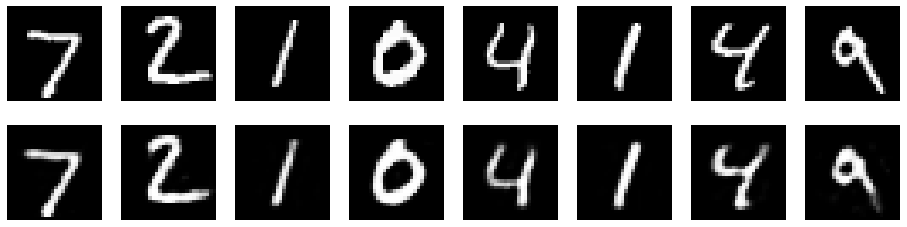

In [8]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=TEST_SIZE)
show_images(np.concatenate((test_imgs, decoded_imgs)))

# Deep autoencoder

In [9]:
HIDDEN_DIM = 48

encoder_deep = Sequential([
    input_layer,
    Flatten(),
    Dense(HIDDEN_DIM * 3, activation='relu'),
    Dense(HIDDEN_DIM * 2, activation='relu'),
    Dense(HIDDEN_DIM, activation='linear'),
])

decoder_deep = Sequential([
    Input(shape=(HIDDEN_DIM,)),
    Dense(HIDDEN_DIM * 2, activation='relu'),
    Dense(HIDDEN_DIM * 3, activation='relu'),
    Dense(IMAGE_Y * IMAGE_X * IMAGE_CH, activation='sigmoid'),
    Reshape((IMAGE_Y, IMAGE_X, IMAGE_CH)),
])

autoencoder_deep = Model(
    input_layer, decoder_deep(encoder_deep(input_layer)), name='autoencoder_deep'
)
autoencoder_deep.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_deep.summary()

Model: "autoencoder_deep"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 48)                131616    
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         132352    
Total params: 263,968
Trainable params: 263,968
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder_deep.fit(
    x=X_train,
    y=X_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)],
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

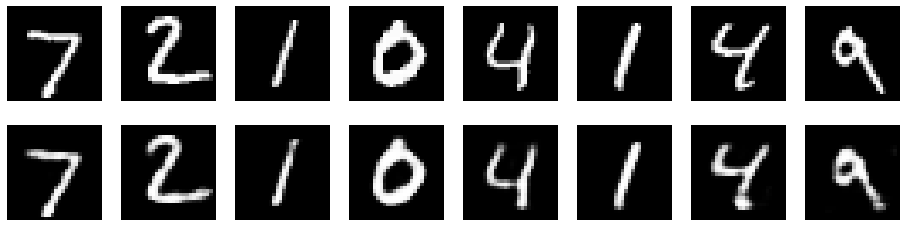

In [11]:
decoded_imgs = autoencoder_deep.predict(test_imgs, batch_size=TEST_SIZE)
show_images(np.concatenate((test_imgs, decoded_imgs)))

# Conv. autoencoder

In [12]:
encoder_conv = Sequential([
    input_layer,
    Conv2D(128, (7, 7), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (2, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(1, (7, 7), activation='relu', padding='same'),
])

decoder_conv = Sequential([
    Input(shape=(7, 7, 1)),
    Conv2D(32, (7, 7), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (7, 7), activation='sigmoid', padding='same'),
])

autoencoder_conv = Model(
    input_layer, decoder_conv(encoder_conv(input_layer)), name='autoencoder_conv'
)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()

Model: "autoencoder_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 7, 7, 1)           24385     
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28, 1)         24385     
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder_conv.fit(
    x=X_train,
    y=X_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)],
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2021-12-12 10:34:02.109808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


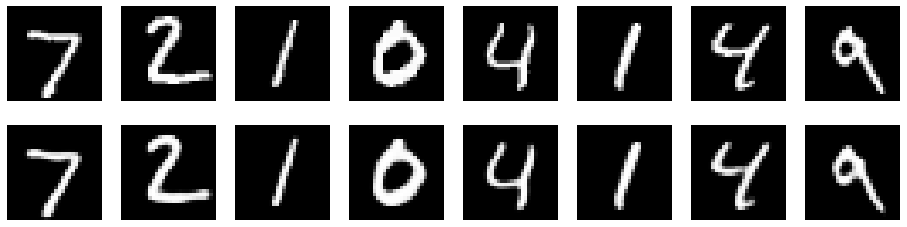

In [14]:
decoded_imgs = autoencoder_conv.predict(test_imgs, batch_size=TEST_SIZE)
show_images(np.concatenate((test_imgs, decoded_imgs)))

# Denoise autoencoder

In [15]:
import keras.backend as K
from keras.layers import Lambda

def add_noise(x):
    noise_factor = 0.5
    x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
    x = K.clip(x, 0., 1.)
    return x

input_lb = Input(batch_shape=(TEST_SIZE, IMAGE_Y, IMAGE_X, IMAGE_CH))
noise_layer = Lambda(add_noise)(input_lb)
noiser = Model(input_lb, noise_layer, name='noiser')
denoiser = Model(
    input_lb, autoencoder(noiser(input_lb)), name='denoiser'
)
denoiser.compile(optimizer='adam', loss='binary_crossentropy')
denoiser.summary()

Model: "denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(8, 28, 28, 1)]          0         
_________________________________________________________________
noiser (Functional)          (8, 28, 28, 1)            0         
_________________________________________________________________
autoencoder (Functional)     (None, 28, 28, 1)         76096     
Total params: 76,096
Trainable params: 76,096
Non-trainable params: 0
_________________________________________________________________


In [16]:
denoiser.fit(
    x=X_train,
    y=X_train,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)],
    batch_size=TEST_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test)
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

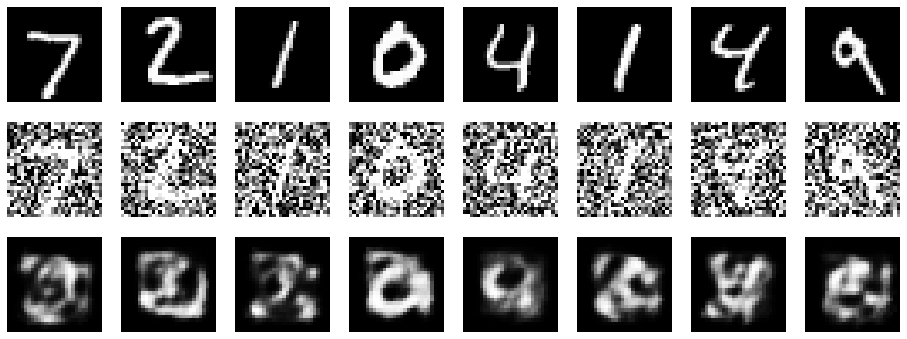

In [17]:
noised_imgs = noiser.predict(test_imgs[:TEST_SIZE], batch_size=TEST_SIZE)
denoised_imgs = denoiser.predict(noised_imgs, batch_size=TEST_SIZE)
show_images(
    np.concatenate((test_imgs, noised_imgs, denoised_imgs)),
    size=(3, 8)
)

# Sparce autoencoder

In [18]:
#from keras.regularizers import L1L2